In [1]:
import pandas as pd
import os
import re
import openpyxl

In [2]:
print(os.getcwd())

/home/notvisal/Desktop/Intern/Knife_Sharpness_Dataset


In [3]:
P1_contents = os.listdir('Theme2/P1/Boning/')

print(P1_contents)

['MVN-J-Boning-64-001.xlsx', 'MVN-J-Boning-90-003.xlsx', 'MVN-J-Boning-90-002.xlsx', 'MVN-J-Boning-90-004.xlsx', 'MVN-J-Boning-64-006.xlsx', 'MVN-J-Boning-64-004.xlsx', 'MVN-J-Boning-64-002.xlsx', 'MVN-J-Boning-90-001.xlsx', 'MVN-J-Boning-64-003.xlsx', 'MVN-J-Boning-79-001.xlsx', 'MVN-J-Boning-64-005.xlsx']


In [4]:
P1_BONING_PATHS = [
    'Theme2/P1/Boning/MVN-J-Boning-64-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-003.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-002.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-006.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-002.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-003.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-79-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-005.xlsx'
]

SELECTED_SHEETS = [
    'General Information', 
    'Markers', 
    'Segment Orientation - Quat', 
    'Segment Orientation - Euler', 
    'Segment Position', 
    'Segment Velocity', 
    'Segment Acceleration', 
    'Segment Angular Velocity', 
    'Segment Angular Acceleration', 
    'Joint Angles ZXY', 
    'Joint Angles XZY', 
    'Ergonomic Joint Angles ZXY', 
    'Ergonomic Joint Angles XZY', 
    'Center of Mass', 
    'Sensor Free Acceleration', 
    'Sensor Magnetic Field', 
    'Sensor Orientation - Quat', 
    'Sensor Orientation - Euler'
]

In [129]:
xls_file = pd.ExcelFile(P1_BONING_PATHS[1])

print(xls_file.sheet_names)

df = xls_file.parse('Markers')
df.head()

['General Information', 'Markers', 'Segment Orientation - Quat', 'Segment Orientation - Euler', 'Segment Position', 'Segment Velocity', 'Segment Acceleration', 'Segment Angular Velocity', 'Segment Angular Acceleration', 'Joint Angles ZXY', 'Joint Angles XZY', 'Ergonomic Joint Angles ZXY', 'Ergonomic Joint Angles XZY', 'Center of Mass', 'Sensor Free Acceleration', 'Sensor Magnetic Field', 'Sensor Orientation - Quat', 'Sensor Orientation - Euler']


,Frame,Labelling,Unnamed: 2,Unnamed: 3
0,0- 252,0- Idle,Idle,0.0
1,253-417,3- Reaching,Walking,1.0
2,418-1849,4 - Cutting,Steeling,2.0
3,1851-1923,4 - Cutting (offloading bone from Carcass),Reaching,3.0
4,1924-2061,5- Dropping,Cutting,4.0


In [6]:
# for i in xls_file.sheet_names:
    
#     df = xls_file.parse(i)

#     df.shape

# **Understanding the Dataset (small scale)**

In [11]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import os

# File paths and sharpness levels
file_paths = [
    'Theme2/P1/Boning/MVN-J-Boning-64-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-003.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-79-001.xlsx'
]
sharpness_levels = [64, 90, 79]

# List of sheets to process - you can modify this list based on which data you need
SHEETS_TO_PROCESS = [
    'General Information', 
    'Markers', 
    'Segment Orientation - Quat', 
    'Segment Orientation - Euler', 
    'Segment Position', 
    'Segment Velocity', 
    'Segment Acceleration', 
    'Segment Angular Velocity', 
    'Segment Angular Acceleration', 
    'Joint Angles ZXY', 
    'Joint Angles XZY', 
    'Ergonomic Joint Angles ZXY', 
    'Ergonomic Joint Angles XZY', 
    'Center of Mass', 
    'Sensor Free Acceleration', 
    'Sensor Magnetic Field', 
    'Sensor Orientation - Quat', 
    'Sensor Orientation - Euler'
]

def clean_column_names(df):
    """Fix and standardize column names in mocap data"""
    # Create a mapping of old columns to new columns
    column_mapping = {}
    
    for col in df.columns:
        # Check if column starts with 'Frame' or contains 'Label'
        if 'Frame' in str(col) and 'Label' in str(col):
            # This is likely a malformed header that combines Frame and Label
            # with other elements - try to separate them
            column_mapping[col] = 'Frame'
            
            # Extract the potential label column if it's not a separate column
            if 'Label' not in df.columns:
                # Create a Label column if it doesn't already exist
                df['Label'] = df[col].astype(str)
                
        elif str(col).startswith('Frame'):
            column_mapping[col] = 'Frame'
            
        elif str(col) == 'Label':
            # Keep Label as is
            pass
            
        else:
            # Leave other columns unchanged
            pass
    
    # Apply the mapping
    df = df.rename(columns=column_mapping)
    
    # If there's no Label column but there is a second column, it might be the label
    if 'Label' not in df.columns and len(df.columns) > 1:
        # Try to identify a potential label column based on data type (strings are likely labels)
        for col in df.columns:
            if col != 'Frame':
                # Check if column contains string values
                if df[col].dtype == 'object' or df[col].astype(str).str.isdigit().all() == False:
                    df = df.rename(columns={col: 'Label'})
                    print(f"  Renamed column '{col}' to 'Label' based on content")
                    break
    
    # If still no Label column, create a default one using the Frame values
    if 'Label' not in df.columns:
        df['Label'] = 'movement'  # Default label
        print("  Created default 'Label' column with value 'movement'")
    
    # Ensure Frame column exists
    if 'Frame' not in df.columns and len(df.columns) > 0:
        # Create frame column as index
        df['Frame'] = np.arange(len(df))
        print("  Created 'Frame' column from index")
    
    return df

def extract_mocap_features(df, sheet_name):
    """Extract relevant features from mocap data based on sheet type"""
    # Get basic columns
    essential_cols = ['Frame', 'Label', 'sharpness']
    
    # Add derived features based on sheet type
    feature_cols = []
    
    # For quaternion sheets, extract body segments
    if 'Orientation - Quat' in sheet_name:
        # Pattern to find quaternion components
        pattern = r'(\w+(\s\w+)*)\sq(\d)'
        
        # Find all body segments that have quaternion data
        segments = set()
        for col in df.columns:
            match = re.search(pattern, str(col))
            if match:
                segments.add(match.group(1))  # Extract segment name
        
        # For each segment, calculate features
        for segment in segments:
            # Find all quaternion components for this segment
            q_cols = [col for col in df.columns if f'{segment} q' in str(col)]
            
            # If we have all 4 quaternion components, include them
            if len(q_cols) == 4:
                feature_cols.extend(q_cols)
                
    # For joint angle sheets
    elif 'Joint Angles' in sheet_name:
        # Pattern for joint angles
        pattern = r'(\w+(\s\w+)*)\s([XYZ])'
        
        # Find all joints
        joints = set()
        for col in df.columns:
            match = re.search(pattern, str(col))
            if match:
                joints.add(match.group(1))  # Extract joint name
        
        # For each joint, include all angle components
        for joint in joints:
            # Find all angle components for this joint
            angle_cols = [col for col in df.columns if joint in str(col) and any(ax in str(col) for ax in ['X', 'Y', 'Z'])]
            feature_cols.extend(angle_cols)
    
    # Add other sheet-specific handling as needed
    
    # Combine essential and feature columns
    all_cols = essential_cols + [col for col in feature_cols if col not in essential_cols]
    
    # Keep only columns that exist in the dataframe
    existing_cols = [col for col in all_cols if col in df.columns]
    
    if len(existing_cols) > len(essential_cols):
        return df[existing_cols]
    else:
        # If no specific features found, return all columns
        return df

def standardize_dtypes(df):
    """Ensure consistent data types for key columns"""
    # Convert key columns to consistent data types
    if 'Label' in df.columns:
        df['Label'] = df['Label'].astype(str)
    
    if 'sharpness' in df.columns:
        df['sharpness'] = df['sharpness'].astype(int)
    
    if 'Frame' in df.columns:
        df['Frame'] = df['Frame'].astype(int)
    
    if 'movement_id' in df.columns:
        df['movement_id'] = df['movement_id'].astype(str)
    
    if 'seq_frame' in df.columns:
        df['seq_frame'] = df['seq_frame'].astype(int)
    
    return df

def process_mocap_data(file_paths, sharpness_levels, source_rate=60, target_rate=25, min_sharpness_count=2):
    """
    Process motion capture data from multiple Excel files with different sharpness levels.
    
    Args:
        file_paths: List of paths to Excel files containing mocap data
        sharpness_levels: List of sharpness values corresponding to each file
        source_rate: Original sampling rate in Hz
        target_rate: Target sampling rate in Hz
        min_sharpness_count: Minimum number of sharpness levels a label must appear in
    """
    print("=== SPECIALIZED MOTION CAPTURE DATA PROCESSING ===")
    
    # Calculate downsample factor
    downsample_factor = int(source_rate / target_rate)
    print(f"\nDownsampling from {source_rate}Hz to {target_rate}Hz (factor: {downsample_factor})")
    
    # Dictionary to store processed data by sheet type and sharpness
    sheet_data = defaultdict(dict)
    
    # Dictionary to track labels in each sharpness level
    labels_by_sharpness = defaultdict(lambda: defaultdict(set))
    
    # Step 1: Process all files and extract data by sheet type
    print("\nSTEP 1: Processing each sheet in each file")
    
    for file_path, sharpness in zip(file_paths, sharpness_levels):
        print(f"\nProcessing {file_path} (Sharpness: {sharpness})")
        
        try:
            xls = pd.ExcelFile(file_path)
            
            # Process only the sheets we're interested in
            for sheet_name in xls.sheet_names:
                if sheet_name not in SHEETS_TO_PROCESS:
                    continue
                
                print(f"  Reading sheet: {sheet_name}")
                
                try:
                    # Read the sheet
                    df = pd.read_excel(xls, sheet_name=sheet_name)
                    if df.empty:
                        print(f"  Sheet {sheet_name} is empty, skipping")
                        continue
                    
                    # Clean up column names and ensure Frame/Label columns exist
                    df = clean_column_names(df)
                    
                    # Standardize data types
                    df = standardize_dtypes(df)
                    
                    # Add sharpness column
                    df['sharpness'] = sharpness
                    
                    # Downsample the data
                    df = df.iloc[::downsample_factor].copy().reset_index(drop=True)
                    
                    # Extract relevant features for this sheet type
                    processed_df = extract_mocap_features(df, sheet_name)
                    
                    # Store in our collection
                    if sheet_name not in sheet_data:
                        sheet_data[sheet_name] = {}
                    
                    sheet_data[sheet_name][sharpness] = processed_df
                    
                    # Track labels for this sharpness and sheet
                    for label in processed_df['Label'].unique():
                        labels_by_sharpness[sheet_name][sharpness].add(label)
                    
                    print(f"  Processed {len(processed_df)} rows, {len(processed_df.columns)} columns")
                
                except Exception as e:
                    print(f"  Error processing sheet {sheet_name}: {e}")
        
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
    print("\nSTEP 2: Analyzing and balancing data for each sheet type")
    
    # Final output - one dataframe per sheet type
    final_sheet_data = {}
    
    # Process each sheet type separately
    for sheet_name, sharpness_dfs in sheet_data.items():
        print(f"\nProcessing sheet type: {sheet_name}")
        
        if not sharpness_dfs:
            print(f"  No data for sheet {sheet_name}, skipping")
            continue
        
        # Find common labels across sharpness levels
        all_labels = set()
        for sharpness, labels in labels_by_sharpness[sheet_name].items():
            all_labels.update(labels)
        
        print(f"  Found {len(all_labels)} unique labels across all sharpness levels")
        
        # For each label, count how many sharpness levels it appears in
        label_presence = defaultdict(int)
        for sharpness, labels in labels_by_sharpness[sheet_name].items():
            for label in labels:
                label_presence[label] += 1
        
        # Filter labels that appear in at least min_sharpness_count levels
        common_labels = [label for label, count in label_presence.items() 
                         if count >= min_sharpness_count]
        
        print(f"  {len(common_labels)} labels appear in at least {min_sharpness_count} sharpness levels")
        
        if not common_labels and all_labels:
            print("  Falling back to using all labels since none meet the minimum count requirement")
            common_labels = list(all_labels)
        
        # For each common label, find the minimum count across sharpness levels
        min_counts = {}
        for label in common_labels:
            counts = []
            for sharpness, df in sharpness_dfs.items():
                if label in df['Label'].unique():
                    count = len(df[df['Label'] == label])
                    counts.append(count)
            
            if counts:
                min_counts[label] = min(counts)
                print(f"  Label '{label}': minimum count = {min_counts[label]}")
        
        # Balance data for each sharpness level
        balanced_dfs = []
        
        for sharpness, df in sharpness_dfs.items():
            print(f"  Balancing sharpness {sharpness}:")
            
            balanced_labels = []
            for label in common_labels:
                label_df = df[df['Label'] == label]
                
                if label_df.empty:
                    print(f"    Label '{label}' not present in sharpness {sharpness}")
                    continue
                
                min_count = min_counts.get(label, 0)
                if min_count <= 0:
                    continue
                
                # Balance by sampling
                if len(label_df) > min_count:
                    # Sample systematically rather than randomly
                    # This preserves the time-series nature of the data better
                    step = len(label_df) // min_count
                    indices = np.arange(0, len(label_df), step)[:min_count]
                    balanced_label = label_df.iloc[indices].reset_index(drop=True)
                    print(f"    Label '{label}': {len(label_df)} → {len(balanced_label)} samples")
                else:
                    balanced_label = label_df
                    print(f"    Label '{label}': kept all {len(label_df)} samples")
                
                balanced_labels.append(balanced_label)
            
            if balanced_labels:
                balanced_df = pd.concat(balanced_labels, ignore_index=True)
                print(f"    Balanced data for sharpness {sharpness}: {balanced_df.shape}")
                balanced_dfs.append(balanced_df)
            else:
                print(f"    No labels to balance for sharpness {sharpness}")
        
        # Combine balanced data for this sheet type
        if balanced_dfs:
            sheet_final = pd.concat(balanced_dfs, ignore_index=True)
            
            # Ensure consistent data types for key columns
            sheet_final = standardize_dtypes(sheet_final)
            
            # Verify balance
            balance_check = sheet_final.groupby(['sharpness', 'Label']).size().unstack(fill_value=0)
            print(f"  Final data shape for sheet {sheet_name}: {sheet_final.shape}")
            print("  Balance check:")
            print(balance_check)
            
            # Store final data for this sheet type
            final_sheet_data[sheet_name] = sheet_final
        else:
            print(f"  No balanced data for sheet {sheet_name}")
    
    print("\nSTEP 3: Creating a unified dataframe with flexible merging approach")
    
    if not final_sheet_data:
        print("No sheet data to merge!")
        return None
    
    print("\nIdentifying columns that appear in multiple sheets (collisions):")
    # Track all unique column names for collision detection
    all_columns = {}  # Maps column name to sheet name where it was found
    
    # Identify columns that appear in multiple sheets (potential collisions)
    for sheet_name, df in final_sheet_data.items():
        for col in df.columns:
            if col not in ['Frame', 'Label', 'sharpness']:  # Skip common columns
                if col in all_columns:
                    # Column exists in another sheet - mark as collision
                    all_columns[col] = None  # None indicates a collision
                else:
                    # First time seeing this column
                    all_columns[col] = sheet_name
    
    # Create a column mapping strategy
    column_mapping = {}
    collisions = [col for col, sheet in all_columns.items() if sheet is None]
    
    if collisions:
        print(f"Found {len(collisions)} column name collisions that need prefixing:")
        for col in collisions[:10]:  # Show just the first 10
            print(f"  - '{col}'")
        if len(collisions) > 10:
            print(f"  ... and {len(collisions) - 10} more")
            
        # Create mappings for colliding columns
        for col, sheet in all_columns.items():
            if sheet is None:
                # This is a collision - we need unique names for each sheet
                for sheet_name, df in final_sheet_data.items():
                    if col in df.columns:
                        # This sheet has the colliding column - create a mapping
                        sheet_prefix = sheet_name.split(' ')[0].lower()  # Use first word of sheet name
                        new_col = f"{sheet_prefix}_{col}"
                        if (sheet_name, col) not in column_mapping:
                            column_mapping[(sheet_name, col)] = new_col
    else:
        print("No column name collisions found - all columns have unique names")
    
    # Apply column renaming to avoid collisions
    renamed_sheet_data = {}
    for sheet_name, df in final_sheet_data.items():
        # Create a rename mapping for this dataframe
        rename_cols = {}
        for (s, c), new_c in column_mapping.items():
            if s == sheet_name and c in df.columns:
                rename_cols[c] = new_c
        
        # Apply renaming if needed
        if rename_cols:
            renamed_df = df.rename(columns=rename_cols)
            print(f"  Renamed {len(rename_cols)} columns in '{sheet_name}' data")
        else:
            renamed_df = df.copy()
        
        # Ensure consistent data types
        renamed_df = standardize_dtypes(renamed_df)
        renamed_sheet_data[sheet_name] = renamed_df
    
    # Create a sequential approach for merging
    print("\nUsing a flexible merging approach that aligns by label group:")
    
    # 1. Create movement IDs based on Label and sharpness combinations
    # This will help us group related frames together
    for sheet_name, df in renamed_sheet_data.items():
        # Add a movement_id column: combine label and sharpness
        # Ensure both are converted to strings first
        df['movement_id'] = df['Label'].astype(str) + '_' + df['sharpness'].astype(str)
        
        # Add a sequential frame count within each movement
        df['seq_frame'] = df.groupby('movement_id').cumcount()
        
        # Update the dataframe
        renamed_sheet_data[sheet_name] = df
    
    # 2. Find common movement_ids across all sheets
    movement_ids_by_sheet = {}
    for sheet_name, df in renamed_sheet_data.items():
        movement_ids_by_sheet[sheet_name] = set(df['movement_id'].unique())
    
    # Get movement IDs that appear in all sheets
    common_movement_ids = set.intersection(*movement_ids_by_sheet.values()) if movement_ids_by_sheet else set()
    
    if not common_movement_ids:
        print("No common movements found across all sheets!")
        print("Will merge all movements from all sheets, but data might not align well.")
        # Just use all movement IDs
        all_movement_ids = set()
        for mids in movement_ids_by_sheet.values():
            all_movement_ids.update(mids)
        common_movement_ids = all_movement_ids
    
    print(f"Found {len(common_movement_ids)} common movement groups across sheets")
    
    # Convert sheet data to list for simpler processing
    sheet_list = list(renamed_sheet_data.items())
    
    # 3. Instead of trying to merge all at once, try a more robust approach
    print("\nUsing pairwise merging approach:")
    
    # Start with the first dataframe
    first_sheet_name, first_df = sheet_list[0]
    print(f"Starting with '{first_sheet_name}' data, shape: {first_df.shape}")
    merged_df = first_df.copy()
    
    # Only keep rows with movement_ids in the common set
    merged_df = merged_df[merged_df['movement_id'].isin(common_movement_ids)]
    print(f"After filtering for common movements: {merged_df.shape}")
    
    # Use concat instead of merge for more robustness
    all_dfs = [merged_df]
    
    for sheet_name, df in sheet_list[1:]:
        # Filter for common movement IDs
        filtered_df = df[df['movement_id'].isin(common_movement_ids)]
        print(f"Adding '{sheet_name}' data, shape after filtering: {filtered_df.shape}")
        
        if not filtered_df.empty:
            all_dfs.append(filtered_df)
    
    print(f"Concatenating {len(all_dfs)} dataframes...")
    try:
        # Instead of merging, concatenate all dataframes
        result = pd.concat(all_dfs, ignore_index=True, sort=False)
        
        # Group by movement_id and seq_frame to combine data from different sheets
        group_cols = ['movement_id', 'seq_frame', 'Label', 'sharpness']
        print(f"Grouping by {group_cols} to align data from different sheets...")
        
        # Check data types of grouping columns
        print("Data types of grouping columns:")
        for col in group_cols:
            print(f"  {col}: {result[col].dtype}")
        
        # Special handling for potential duplicate columns across sheets
        # Identify all columns except grouping columns
        data_cols = [col for col in result.columns if col not in group_cols]
        
        # Use first non-null value for each group
        agg_dict = {col: 'first' for col in data_cols}
        
        # Group and aggregate
        final_df = result.groupby(group_cols, as_index=False).agg(agg_dict)
        
        # Drop temporary columns
        if 'seq_frame' in final_df.columns:
            final_df = final_df.drop(columns=['seq_frame'])
        
        if 'movement_id' in final_df.columns:
            final_df = final_df.drop(columns=['movement_id'])
        
        # Sort by sharpness, Label, and Frame for a clean result
        if 'Frame' in final_df.columns:
            final_df = final_df.sort_values(['sharpness', 'Label', 'Frame']).reset_index(drop=True)
        
        # Report final shape and column count
        print(f"Final dataframe shape: {final_df.shape}")
        print(f"Total columns: {len(final_df.columns)}")
        
        # Check for NaN values
        nan_pct = final_df.isna().mean().mean() * 100
        print(f"NaN percentage in final data: {nan_pct:.2f}%")
        
        return final_df
        
    except Exception as e:
        print(f"Error during concatenation: {e}")
        # Try a different approach - use pandas concat to append data from all sheets
        print("\nAttempting alternate approach using direct concatenation...")
        
        # Just append all data from all sheets
        concatenated_df = pd.concat([df for _, df in renamed_sheet_data.items()], ignore_index=True)
        
        print(f"Concatenated data shape: {concatenated_df.shape}")
        
        # Drop temporary columns
        if 'seq_frame' in concatenated_df.columns:
            concatenated_df = concatenated_df.drop(columns=['seq_frame'])
        
        if 'movement_id' in concatenated_df.columns:
            concatenated_df = concatenated_df.drop(columns=['movement_id'])
        
        return concatenated_df

def main():
    try:
        # Process the data
        merged_df = process_mocap_data(
            file_paths=file_paths,
            sharpness_levels=sharpness_levels,
            source_rate=60,
            target_rate=25,
            min_sharpness_count=2
        )
        
        if merged_df is None or merged_df.empty:
            print("No results generated!")
            return
        
        # Save the final merged dataframe
        output_file = "unified_mocap_data.csv"
        merged_df.to_csv(output_file, index=False)
        print(f"\nSaved unified data to {output_file} ({merged_df.shape[0]} rows, {merged_df.shape[1]} columns)")
        
        # Show column list
        print("\nColumns in final dataset:")
        for i, col in enumerate(sorted(merged_df.columns), 1):
            print(f"{i:3d}. {col}")
        
        # Show sample data
        print("\nSample of unified data:")
        print(merged_df.head(2))
        
        print("\n=== PROCESSING COMPLETED SUCCESSFULLY ===")
    
    except Exception as e:
        print(f"ERROR IN PROCESSING: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

=== SPECIALIZED MOTION CAPTURE DATA PROCESSING ===

Downsampling from 60Hz to 25Hz (factor: 2)

STEP 1: Processing each sheet in each file

Processing Theme2/P1/Boning/MVN-J-Boning-64-004.xlsx (Sharpness: 64)
  Reading sheet: General Information
  Renamed column 'MVN version' to 'Label' based on content
  Created 'Frame' column from index
  Processed 3 rows, 4 columns
  Reading sheet: Markers
  Renamed column 'Labelling' to 'Label' based on content
  Error processing sheet Markers: invalid literal for int() with base 10: '0- 1032'
  Reading sheet: Segment Orientation - Quat
  Processed 2517 rows, 95 columns
  Reading sheet: Segment Orientation - Euler
  Processed 2517 rows, 72 columns
  Reading sheet: Segment Position
  Processed 2517 rows, 72 columns
  Reading sheet: Segment Velocity
  Processed 2517 rows, 72 columns
  Reading sheet: Segment Acceleration
  Processed 2517 rows, 72 columns
  Reading sheet: Segment Angular Velocity
  Processed 2517 rows, 72 columns
  Reading sheet: Segme

In [14]:
print(os.getcwd())

print(os.listdir())

/home/notvisal/Desktop/Intern/Knife_Sharpness_Dataset
['.idea', 'Boning_64_merged.xlsx', 'unified_mocap_data.csv', 'HOME', 'KS.ipynb', 'Theme2.zip', '.python-version', 'token.txt', '.git', '.ipynb_checkpoints', 'Theme2', '.venv', 'merged_output', 'data.ipynb']


In [48]:
df = pd.read_csv('unified_mocap_data.csv', low_memory=False)
df.head()

,Label,sharpness,2023.0.0,Frame,segment_T12 q0,segment_T12 q1,segment_T12 q2,segment_T12 q3,segment_Neck q0,segment_Neck q1,...,sensor_Right Upper Leg q2,sensor_Right Upper Leg q3,sensor_Right Forearm q0,sensor_Right Forearm q1,sensor_Right Forearm q2,sensor_Right Forearm q3,sensor_Right Shoulder q0,sensor_Right Shoulder q1,sensor_Right Shoulder q2,sensor_Right Shoulder q3
0,0,64,NaN,1034,0.677763,0.077669,-0.085521,0.726148,0.621440,-0.004236,...,0.686605,0.146609,0.493994,-0.013271,0.725831,0.478501,0.184242,-0.094016,0.478588,-0.853328
1,0,64,NaN,1036,0.674951,0.081303,-0.089517,0.727886,0.619346,0.000718,...,0.687268,0.147925,0.497658,-0.008489,0.729378,0.469332,0.186919,-0.092753,0.484455,-0.849565
2,0,64,NaN,1038,0.673722,0.084602,-0.092875,0.728227,0.618565,0.005038,...,0.686725,0.149768,0.501317,0.002028,0.735149,0.456326,0.187315,-0.091881,0.489405,-0.846731
3,0,64,NaN,1040,0.672421,0.087813,-0.095949,0.728651,0.617388,0.008892,...,0.687191,0.153397,0.505823,0.016446,0.740413,0.442337,0.187596,-0.091951,0.494359,-0.843778
4,0,64,NaN,1042,0.671150,0.091016,-0.099445,0.728961,0.616614,0.012539,...,0.688858,0.157203,0.510211,0.031248,0.745717,0.427334,0.189187,-0.091046,0.498664,-0.840983


# **Normalization**

In [88]:
import tensorflow as tf
import numpy as np

mocap_df = pd.read_csv('unified_mocap_data.csv', low_memory=False)

nan_counts = mocap_df.isna().sum()
cols_with_nan = nan_counts[nan_counts > 0]
print(cols_with_nan)

2023.0.0                    7493
segment_T12 q0               125
segment_T12 q1               125
segment_T12 q2               125
segment_T12 q3               125
                            ... 
sensor_Right Forearm q3      125
sensor_Right Shoulder q0     125
sensor_Right Shoulder q1     125
sensor_Right Shoulder q2     125
sensor_Right Shoulder q3     125
Length: 416, dtype: int64


In [89]:
mocap_df.head()

,Label,sharpness,2023.0.0,Frame,segment_T12 q0,segment_T12 q1,segment_T12 q2,segment_T12 q3,segment_Neck q0,segment_Neck q1,...,sensor_Right Upper Leg q2,sensor_Right Upper Leg q3,sensor_Right Forearm q0,sensor_Right Forearm q1,sensor_Right Forearm q2,sensor_Right Forearm q3,sensor_Right Shoulder q0,sensor_Right Shoulder q1,sensor_Right Shoulder q2,sensor_Right Shoulder q3
0,0,64,NaN,1034,0.677763,0.077669,-0.085521,0.726148,0.621440,-0.004236,...,0.686605,0.146609,0.493994,-0.013271,0.725831,0.478501,0.184242,-0.094016,0.478588,-0.853328
1,0,64,NaN,1036,0.674951,0.081303,-0.089517,0.727886,0.619346,0.000718,...,0.687268,0.147925,0.497658,-0.008489,0.729378,0.469332,0.186919,-0.092753,0.484455,-0.849565
2,0,64,NaN,1038,0.673722,0.084602,-0.092875,0.728227,0.618565,0.005038,...,0.686725,0.149768,0.501317,0.002028,0.735149,0.456326,0.187315,-0.091881,0.489405,-0.846731
3,0,64,NaN,1040,0.672421,0.087813,-0.095949,0.728651,0.617388,0.008892,...,0.687191,0.153397,0.505823,0.016446,0.740413,0.442337,0.187596,-0.091951,0.494359,-0.843778
4,0,64,NaN,1042,0.671150,0.091016,-0.099445,0.728961,0.616614,0.012539,...,0.688858,0.157203,0.510211,0.031248,0.745717,0.427334,0.189187,-0.091046,0.498664,-0.840983


In [90]:
metadata_cols = ['Frame', 'Label', 'sharpness']
mocap_df = mocap_df.drop('2023.0.0', axis=1)
feature_cols = [col for col in mocap_df.columns if col not in metadata_cols]

mocap_df[feature_cols] = mocap_df[feature_cols].fillna(method='ffill')
mocap_df[feature_cols] = mocap_df[feature_cols].fillna(method='bfill')

/tmp/ipykernel_4719/2036508186.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mocap_df[feature_cols] = mocap_df[feature_cols].fillna(method='ffill')
/tmp/ipykernel_4719/2036508186.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mocap_df[feature_cols] = mocap_df[feature_cols].fillna(method='bfill')


In [91]:
mocap_df.head()

,Label,sharpness,Frame,segment_T12 q0,segment_T12 q1,segment_T12 q2,segment_T12 q3,segment_Neck q0,segment_Neck q1,segment_Neck q2,...,sensor_Right Upper Leg q2,sensor_Right Upper Leg q3,sensor_Right Forearm q0,sensor_Right Forearm q1,sensor_Right Forearm q2,sensor_Right Forearm q3,sensor_Right Shoulder q0,sensor_Right Shoulder q1,sensor_Right Shoulder q2,sensor_Right Shoulder q3
0,0,64,1034,0.677763,0.077669,-0.085521,0.726148,0.621440,-0.004236,-0.005306,...,0.686605,0.146609,0.493994,-0.013271,0.725831,0.478501,0.184242,-0.094016,0.478588,-0.853328
1,0,64,1036,0.674951,0.081303,-0.089517,0.727886,0.619346,0.000718,-0.013304,...,0.687268,0.147925,0.497658,-0.008489,0.729378,0.469332,0.186919,-0.092753,0.484455,-0.849565
2,0,64,1038,0.673722,0.084602,-0.092875,0.728227,0.618565,0.005038,-0.020151,...,0.686725,0.149768,0.501317,0.002028,0.735149,0.456326,0.187315,-0.091881,0.489405,-0.846731
3,0,64,1040,0.672421,0.087813,-0.095949,0.728651,0.617388,0.008892,-0.026550,...,0.687191,0.153397,0.505823,0.016446,0.740413,0.442337,0.187596,-0.091951,0.494359,-0.843778
4,0,64,1042,0.671150,0.091016,-0.099445,0.728961,0.616614,0.012539,-0.032648,...,0.688858,0.157203,0.510211,0.031248,0.745717,0.427334,0.189187,-0.091046,0.498664,-0.840983


## **Data VIS**

Unique sharpness levels: [64 79 90]


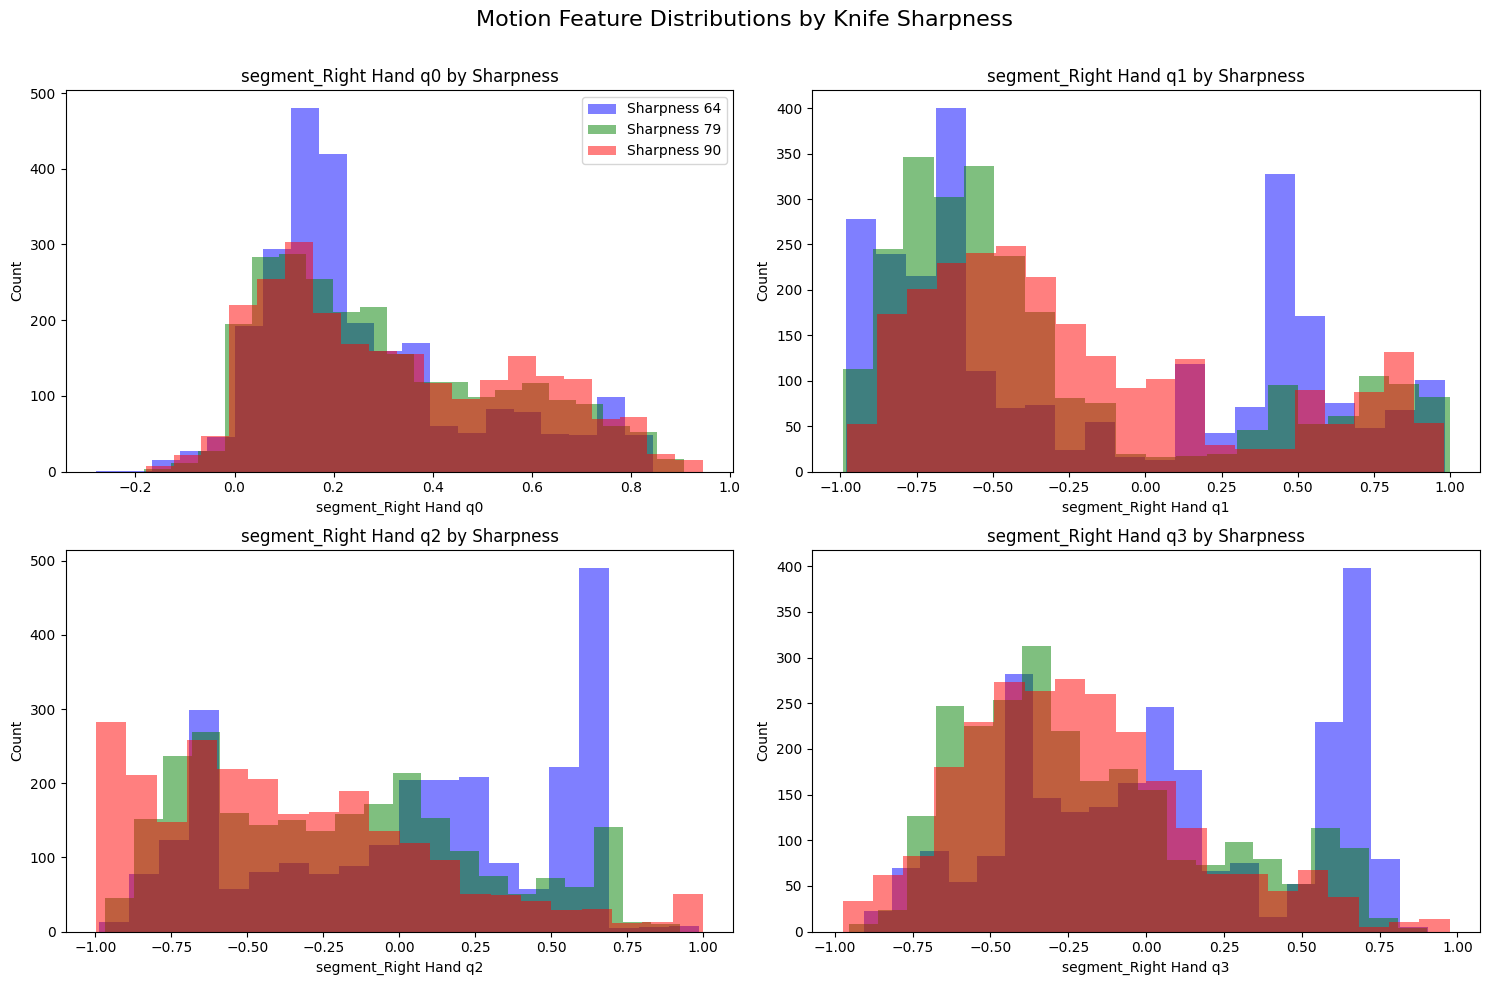

In [139]:
import matplotlib.pyplot as plt

# Verify sharpness levels
unique_sharpness = np.sort(mocap_df['sharpness'].unique())
print(f"Unique sharpness levels: {unique_sharpness}")

# Create visualization to show motion differences across sharpness levels
plt.figure(figsize=(15, 10))
plt.suptitle("Motion Feature Distributions by Knife Sharpness", fontsize=16)

# Select a few representative features
selected_features = feature_cols[60:64]  # First 4 features - change if needed

# Create color mapping for sharpness levels
sharpness_colors = {
    64: 'blue',
    79: 'green',
    90: 'red'
}

# Create histograms for different features
for i, feature in enumerate(selected_features):
    plt.subplot(2, 2, i+1)
    
    for sharpness in unique_sharpness:
        # Get data for this sharpness
        sharp_data = mocap_df[mocap_df['sharpness'] == sharpness][feature]
        plt.hist(sharp_data, alpha=0.5, bins=20, 
                 color=sharpness_colors[sharpness],
                 label=f'Sharpness {sharpness}')
    
    plt.title(f"{feature} by Sharpness")
    plt.xlabel(feature)
    plt.ylabel('Count')
    if i == 0:  # Only add legend to first plot
        plt.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [92]:
normalizer = tf.keras.layers.Normalization(axis=-1)
feature_data = mocap_df[feature_cols].values
normalizer.adapt(feature_data)
normalized_features = normalizer(feature_data).numpy()

In [93]:
print(f"Mean of normalized features: {np.mean(normalized_features)}")
print(f"STD of normalized features: {np.std(normalized_features):.6f}")

Mean of normalized features: -1.806918703550764e-08
STD of normalized features: 0.939110


In [140]:
sharpness_mapping = {val: i for i, val in enumerate(unique_sharpness)}
y_sharp_class = np.array([sharpness_mapping[val] for val in mocap_df['sharpness']])
num_sharpness_classes = len(unique_sharpness)

In [141]:
print(f"Sharpness mapping: {sharpness_mapping}")
print(f"Number of sharpness classes: {num_sharpness_classes}")

Sharpness mapping: {np.int64(64): 0, np.int64(79): 1, np.int64(90): 2}
Number of sharpness classes: 3


In [142]:
X_tensor = tf.convert_to_tensor(normalized_features, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y_sharp_class, dtype=tf.float32)

In [143]:
dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
dataset = dataset.shuffle(buffer_size=len(normalized_features), seed=42)

In [144]:
train_size = int(0.8 * len(normalized_features))

In [146]:
BATCH_SIZE = 64

train_dataset = dataset.take(train_size).batch(BATCH_SIZE)
test_dataset = dataset.skip(train_size).batch(BATCH_SIZE)

## **NN for Classification model**

In [159]:
# Build a neural network classification model
num_features = normalized_features.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(num_features,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(num_sharpness_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )
    ]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

/home/notvisal/.pyenv/versions/3.12.3/envs/InternEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 256)            │       106,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,635 (584.51 KB)

 Trainable params: 148,739 (581.01 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6501 - loss: 0.8514 - val_accuracy: 0.9067 - val_loss: 0.2473
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9024 - loss: 0.2560 - val_accuracy: 0.9607 - val_loss: 0.1058
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9423 - loss: 0.1647 - val_accuracy: 0.9873 - val_loss: 0.0423
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9527 - loss: 0.1279 - val_accuracy: 0.9867 - val_loss: 0.0382
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9640 - loss: 0.1041 - val_accuracy: 0.9947 - val_loss: 0.0185
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9707 - loss: 0.0749 - val_accuracy: 0.9940 - val_loss: 0.0202
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 0.0615 - val_accuracy: 0.9967 - val_loss: 0.0118
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9789 - loss: 0.0630 - val_accuracy: 0.9967 - val_loss:

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


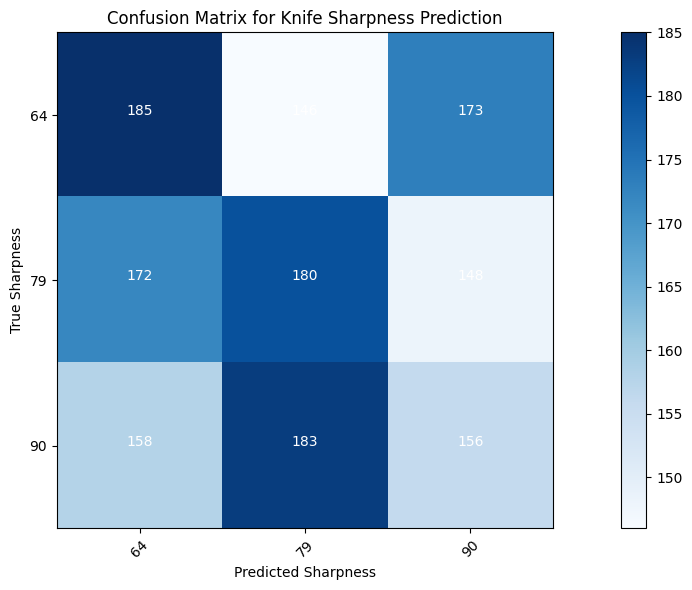

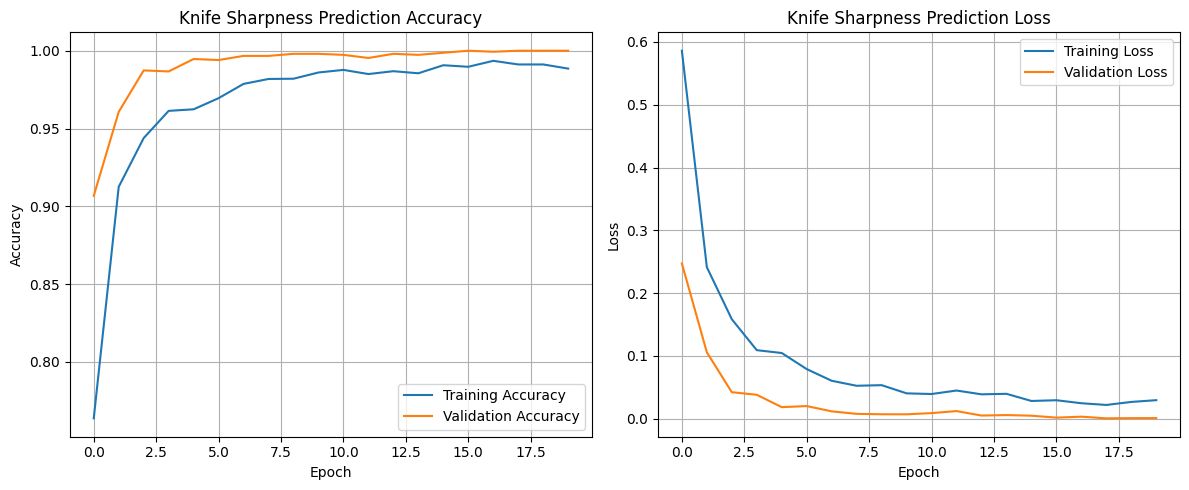

In [160]:
# Create confusion matrix to better understand predictions
y_pred = np.argmax(model.predict(test_dataset), axis=1)
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Convert back to actual sharpness values for interpretation
reverse_mapping = {i: val for val, i in sharpness_mapping.items()}
pred_sharpness = np.array([reverse_mapping[i] for i in y_pred])
true_sharpness = np.array([reverse_mapping[i] for i in y_true])

# Plot confusion matrix manually
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Knife Sharpness Prediction')
plt.colorbar()

# Add labels and values
tick_marks = np.arange(len(unique_sharpness))
plt.xticks(tick_marks, [str(s) for s in unique_sharpness], rotation=45)
plt.yticks(tick_marks, [str(s) for s in unique_sharpness])

# Add text annotations
thresh = confusion_mtx.numpy().max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, format(confusion_mtx[i, j].numpy(), 'd'),
                horizontalalignment="center",
                color="white" if confusion_mtx[i, j].numpy() > thresh else "black")

plt.ylabel('True Sharpness')
plt.xlabel('Predicted Sharpness')
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Knife Sharpness Prediction Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Knife Sharpness Prediction Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()